In [140]:
from utils import *
from numpy import *
import time
import copy
from utils.opt_utils import *
import h5py
import pickle
from qutip import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize

In [2]:
def s_to_tick(s):
    return int(s / (0.145321801 * 1e-9))


In [3]:
wc_A = 4.069814 * (10**9) * 2 * np.pi  # cavity A frequency
wc_B = 6.096062 * (10**9) * 2 * np.pi  # cavity A frequency
wa =  5.325 * (10**9) * 2 * np.pi  # atom frequency
dt_A = np.abs(wc_A - wa) / (2 * np.pi)
dt_B = np.abs(wc_B - wa) / (2 * np.pi)
chi_A = 0.00215 * (10**9) * 2 * np.pi
chi_B = 0.00544 * (10**9) * 2 * np.pi
g_A = np.sqrt(chi_A * dt_A) * 2 * np.pi  # coupling strength w/ cavity A
g_B = np.sqrt(chi_B * dt_B) * 2 * np.pi  # coupling strength w/ cavity B

gamma = 1000.0        # atom dissipation rate
kappa_A = 1000.0       # cavity A dissipation rate
kappa_B = 1000.0       # cavity B dissipation rate

temp_q = 0.001        # avg number of thermal bath excitation for qubit
temp_A = 0.001        # avg number of thermal bath excitation for cavity A
temp_B = 0.001        # avg number of thermal bath excitation for cavity B

In [218]:
# ========== OPTIONS ========== #
ti = 0.0
tf = 5e-6
n_steps = 501
t_step = 0.145321801 * 1e-9
t_list = np.arange(ti, tf, t_step)
eval_t_list = np.linspace(ti, tf, n_steps)

num_cavities = 2
cavity_dims = 8
state_sizes = [2, cavity_dims, cavity_dims]
state_vals = [0, 0, 0]
init_freqs = [wa, wc_A, wc_B]
sim_options = Options()
element_freqs = [wa, wc_A, wc_B]
elements = "qAB"
# ========== OPTIONS ========== #

sim_options.store_states = True
# sim_options.nsteps = 10000

sm, a_A, a_B, sx, sz = reg_ops(num_cavities + 1, cavity_dims)

gammas = [gamma, kappa_A, kappa_B]
temps = [temp_q, temp_A, temp_B]
c_ops = gen_c_ops(elements, [sm, a_A, a_B, sx, sz], gammas, temps)

# Operators used in Hamiltonian
drive_ops = [sm.dag(), sm, a_A.dag(), a_A, a_B.dag(), a_B]
element_ops = [sz, a_A.dag() * a_A, a_B.dag() * a_B]
H_0 = (chi_A * a_A.dag() * a_A * sz / 2) + (chi_B * a_B.dag() * a_B * sz / 2)
eval_ops = [sm.dag() * sm, a_A.dag() * a_A, a_B.dag() * a_B]

# Setup initial state
# init_state = build_psi(state_sizes, state_vals)
init_state = tensor((basis(state_sizes[0], 0) * np.sqrt(1 - state_vals[0])) + (basis(state_sizes[0], 1) * np.sqrt(state_vals[0])), (basis(state_sizes[1], 0) * np.sqrt(1 - state_vals[1])) + (basis(state_sizes[1], 1) * np.sqrt(state_vals[1])), (basis(state_sizes[2], 0) * np.sqrt(1 - state_vals[2])) + (basis(state_sizes[2], 1) * np.sqrt(state_vals[2])))

In [219]:
def pulse_eval(H_r, pulse_config, res_func):
    drive_amp_funcs = [[] for i in range(len(drive_ops))]
    
    # Add pulses:
    for cfg in pulse_config:
        # drive_amp_funcs[cfg['ch']].append(gauss_gen(cfg['gain'], cfg['t'] + (2 * cfg['sigma']), cfg['sigma'], 10000000))
        drive_amp_funcs[cfg['ch']].append(gauss_seg(cfg['gain'], cfg['sigma'], cfg['t'], cfg['t'] + (6 * cfg['sigma'])))
    
    comp_amp_funcs = [func_sum(np.array(drive_amp_funcs[i])) for i in range(len(drive_amp_funcs))]
        
    drive_camps = []
    for i in range(int(len(comp_amp_funcs) / 2)):
        drive_camps.append(iq_to_amp(comp_amp_funcs[2 * i], comp_amp_funcs[(2 * i) + 1]))
        drive_camps.append(iq_to_amp(comp_amp_funcs[2 * i], comp_amp_funcs[(2 * i) + 1], conj=True))
        
    H = [H_r]
    for i, drive in enumerate(drive_camps):
        a = [drive_ops[i], drive]
        H.append(a)
    H = QobjEvo(H)
    
    res = mesolve(H=H, rho0=init_state, tlist=eval_t_list, c_ops=c_ops, e_ops=eval_ops, options=sim_options)

    return res_func(np.array(res.expect)[:, -1], res.states[-1])

def pulse_plot(pulse_config):
    drive_amp_funcs = [[] for i in range(len(drive_ops))]
    
    # Add pulses:
    for cfg in pulse_config:
        # drive_amp_funcs[cfg['ch']].append(gauss_gen(cfg['gain'], cfg['t'] + (2 * cfg['sigma']), cfg['sigma'], 10000000))
        # print(len(gauss_gen(cfg['gain'], cfg['t'] + (2 * cfg['sigma']), cfg['sigma'], 10000000)(eval_t_list)))
        drive_amp_funcs[cfg['ch']].append(gauss_seg(cfg['gain'], cfg['sigma'], cfg['t'], cfg['t'] + (6 * cfg['sigma'])))
    
    comp_amp_funcs = [func_sum(np.array(drive_amp_funcs[i])) for i in range(len(drive_amp_funcs))]
        
    drive_camps = []
    for i in range(int(len(comp_amp_funcs) / 2)):
        drive_camps.append(iq_to_amp(comp_amp_funcs[2 * i], comp_amp_funcs[(2 * i) + 1]))
        drive_camps.append(iq_to_amp(comp_amp_funcs[2 * i], comp_amp_funcs[(2 * i) + 1], conj=True))
        
    for i, amps in enumerate(drive_camps):
        plt.plot(t_list, amps(t_list, 0).real, label=f'{i}I')
        plt.plot(t_list, amps(t_list, 0).imag, label=f'{i}Q')
    plt.legend()
    plt.show()
    
def state_plot(H_r, pulse_config):
    drive_amp_funcs = [[] for i in range(len(drive_ops))]
    
    # Add pulses:
    for cfg in pulse_config:
        # drive_amp_funcs[cfg['ch']].append(gauss_gen(cfg['gain'], cfg['t'] + (2 * cfg['sigma']), cfg['sigma'], 10000000))
        drive_amp_funcs[cfg['ch']].append(gauss_seg(cfg['gain'], cfg['sigma'], cfg['t'], cfg['t'] + (6 * cfg['sigma'])))
    
    comp_amp_funcs = [func_sum(np.array(drive_amp_funcs[i])) for i in range(len(drive_amp_funcs))]
        
    drive_camps = []
    for i in range(int(len(comp_amp_funcs) / 2)):
        drive_camps.append(iq_to_amp(comp_amp_funcs[2 * i], comp_amp_funcs[(2 * i) + 1]))
        drive_camps.append(iq_to_amp(comp_amp_funcs[2 * i], comp_amp_funcs[(2 * i) + 1], conj=True))
        
    H = [H_r]
    for i, drive in enumerate(drive_camps):
        a = [drive_ops[i], drive]
        H.append(a)
    H = QobjEvo(H)
    
    res = mesolve(H=H, rho0=init_state, tlist=eval_t_list, c_ops=c_ops, e_ops=eval_ops, options=sim_options)
    
    expect_res = res.expect
    for i, expect in enumerate(expect_res):
        plt.plot(eval_t_list, expect, label=f'{i}')
    # plt.legend()
    plt.show()

In [220]:
def r_x_e_func(x, dm):
    # print(dm[::64, ::64])
    # print(np.shape(dm))
    # print(f'res: {- np.abs(1 - x[0])}')
    return - np.abs(1 - x[0])

def r_x_1_func(x, dm):
    # print(dm)
    return - np.abs(1 - x[1])

def r_dm_e00_func(x, dm):
    print(dm)
    return np.power(np.abs(dm[64][8]), 2)

def r_dm_g10_func(x, dm):
    # print(dm[8])
    # print(f'trace: {dm.tr()}')
    # print(f'argmax: {np.argmax(np.array(dm))}')
    # print(f'res: {dm.diag()[::8]}')
    return np.abs(dm[8, 8])
    # return np.abs(dm[8, 8])

In [176]:
drive_gains = [10000000, 10000000, 10000000]
drive_sigmas = [0.25 * 1e-6, 0.01 * 1e-6, 0.01 * 1e-6]
drive_freqs = [wa, wc_A, wc_B]
drive_ts = [0.0 * 1e-6, 0.02 * 1e-6, 0.02 * 1e-6]

H_r = assemble_ti_hamil(H_0, element_ops, np.array(element_freqs) - np.array(drive_freqs))

In [183]:
delay_i = 0.0
delay_f = 1e-6
n_delays = 10

amp_i = 0
amp_f = 100000000
n_amps = 25

test_delays = np.linspace(delay_i, delay_f, n_delays)

test_amps = np.linspace(amp_i, amp_f, n_amps)

out_list3 = np.empty((n_delays, n_amps, n_amps))
for i, delay in enumerate(test_delays):
    for j, amp1 in enumerate(tqdm(test_amps)):
        for k, amp2 in enumerate(test_amps):

            pulse_config = [
                {
                    "ch": 2,  # Channel to play pulse on
                    "gain": amp1,  # Gain of pulse [DAC units]
                    "freq": drive_freqs[1],  # Frequency to play pulse at [MHz]
                    "sigma": drive_sigmas[1],  # Standard deviation of Gaussian [us]
                    "t": 0.0 * 1e-6  #  # Time at which pulse is sent [us]
                },
                {
                    "ch": 0,  # Channel to play pulse on
                    "gain": 2 * 2500000,  # Gain of pulse [DAC units]
                    "freq": drive_freqs[0],  # Frequency to play pulse at [MHz]
                    "sigma": drive_sigmas[0],  # Standard deviation of Gaussian [us]
                    "t": (0.06 * 1e-6) + delay  # Time at which pulse is sent [us]
                },
                {
                    "ch": 2,  # Channel to play pulse on
                    "gain": amp2,  # Gain of pulse [DAC units]
                    "freq": drive_freqs[1],  # Frequency to play pulse at [MHz]
                    "sigma": drive_sigmas[1],  # Standard deviation of Gaussian [us]
                    "t": (1.56 * 1e-6) + delay  # Time at which pulse is sent [us]
                },
            ]
        
            out_list3[i, j, k] = pulse_eval(H_r, pulse_config, r_dm_g10_func)

100%|██████████| 25/25 [45:13<00:00, 108.52s/it]


In [182]:
# out_list3_pnp = copy.deepcopy(out_list3)

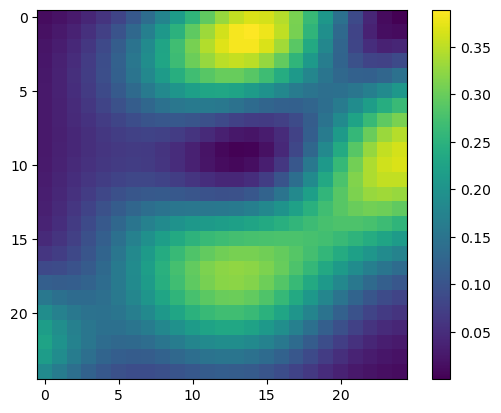

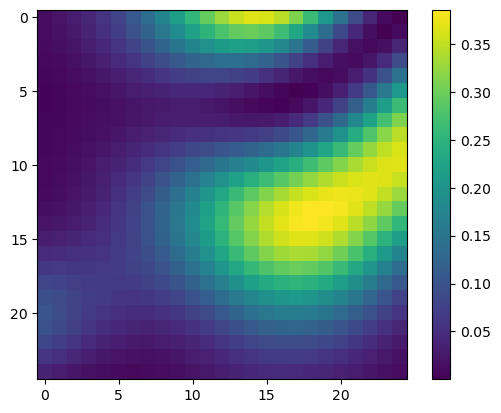

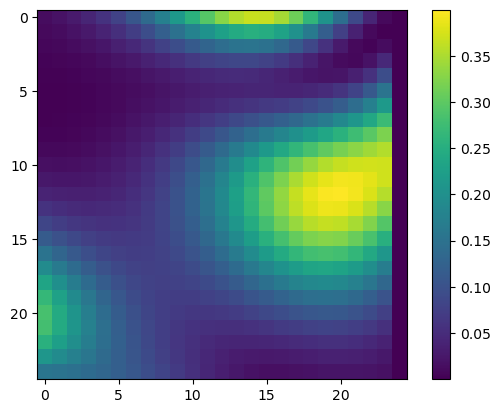

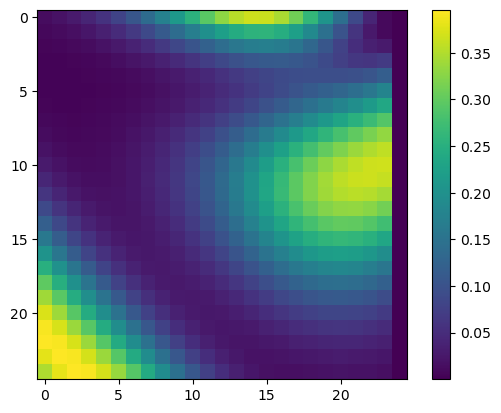

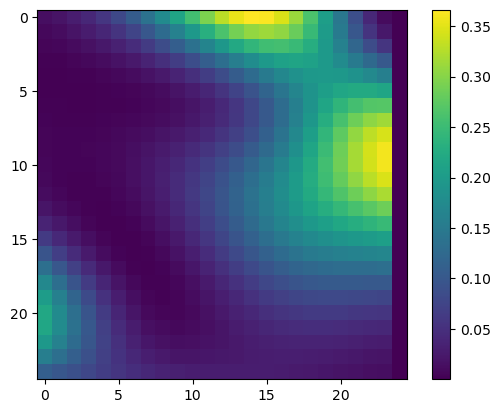

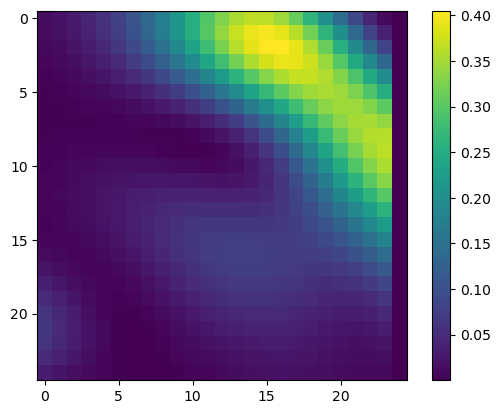

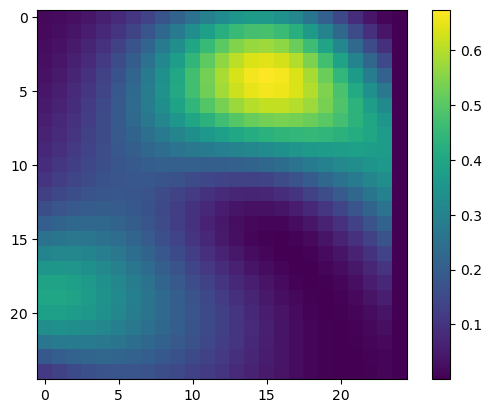

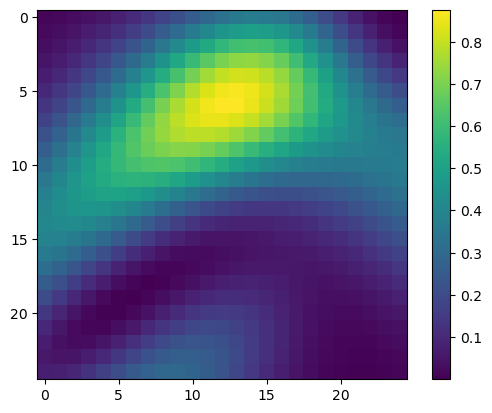

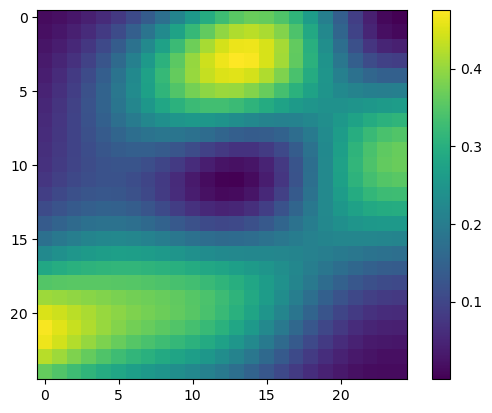

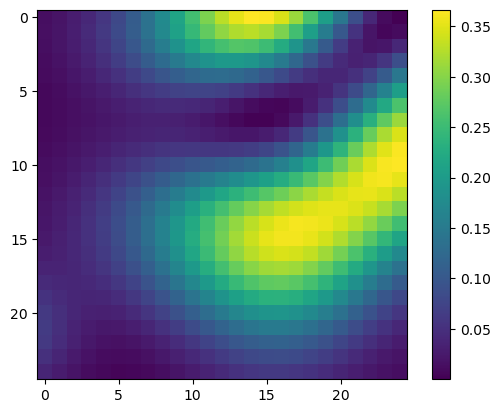

In [187]:
for i in range(n_delays):
    plt.imshow((out_list3[i][::-1]).T)
    plt.colorbar()
    plt.show()

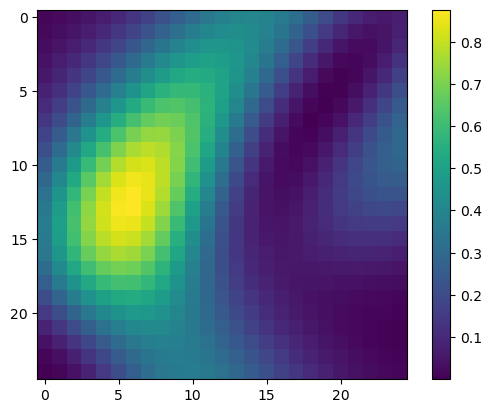

[[2.66454382e-06 1.06761653e-02 4.13513940e-02 8.81064592e-02
  1.45226618e-01 2.06035801e-01 2.63395459e-01 3.11571921e-01
  3.46016185e-01 3.64540257e-01 3.66587074e-01 3.53559049e-01
  3.28215148e-01 2.94124993e-01 2.54847307e-01 2.13979642e-01
  1.74199387e-01 1.37697823e-01 1.05846644e-01 7.92336633e-02
  5.77127927e-02 4.09691281e-02 2.84804521e-02 1.94351288e-02
  1.30956682e-02]
 [1.06397210e-02 3.47961075e-02 7.67372609e-02 1.31083896e-01
  1.91399077e-01 2.50542498e-01 3.02060584e-01 3.41089972e-01
  3.64479981e-01 3.71253300e-01 3.62215905e-01 3.39856483e-01
  3.07398882e-01 2.68831940e-01 2.27556042e-01 1.86661472e-01
  1.48812955e-01 1.15096523e-01 8.66739186e-02 6.34375913e-02
  4.53145427e-02 3.15170144e-02 2.14079983e-02 1.42170556e-02
  9.28422760e-03]
 [4.12169998e-02 7.87806891e-02 1.30890787e-01 1.90983706e-01
  2.51847863e-01 3.06459777e-01 3.49298764e-01 3.76278448e-01
  3.86029329e-01 3.79062464e-01 3.57633925e-01 3.25125283e-01
  2.85523472e-01 2.42563519e-01 1.

In [191]:
plt.imshow(out_list3[7][::-1])
plt.colorbar()
plt.show()
print(out_list3[7])
print(out_list3[7, 12, 6])
print(test_delays[7])
print(f'test_amp1: {test_amps[12]}')
print(f'test_amp2: {test_amps[6]}')

In [37]:
amp_i = 0
amp_f = 100000000
n_amps = 101

test_amps = np.linspace(amp_i, amp_f, n_amps)

out_list2 = np.empty((n_amps, n_amps))
for i, amp1 in tqdm(enumerate(test_amps)):
    for j, amp2 in enumerate(test_amps):
        
        pulse_config = [
        {
            "ch": 2,  # Channel to play pulse on
            "gain": amp1,  # Gain of pulse [DAC units]
            "freq": drive_freqs[1],  # Frequency to play pulse at [MHz]
            "sigma": drive_sigmas[1],  # Standard deviation of Gaussian [us]
            "t": 0.0 * 1e-6  #  # Time at which pulse is sent [us]
        },
        {
            "ch": 0,  # Channel to play pulse on
            "gain": 2500000,  # Gain of pulse [DAC units]
            "freq": drive_freqs[0],  # Frequency to play pulse at [MHz]
            "sigma": drive_sigmas[0],  # Standard deviation of Gaussian [us]
            "t": 0.06 * 1e-6 #  # Time at which pulse is sent [us]
        },
        {
            "ch": 2,  # Channel to play pulse on
            "gain": -amp2,  # Gain of pulse [DAC units]
            "freq": drive_freqs[1],  # Frequency to play pulse at [MHz]
            "sigma": drive_sigmas[1],  # Standard deviation of Gaussian [us]
            "t": 1.56 * 1e-6  # Time at which pulse is sent [us]
        },
        ]
        
        out_list2[i, j] = pulse_eval(H_r, pulse_config, r_dm_g10_func)

101it [9:52:50, 352.19s/it]


0.07318709150816503


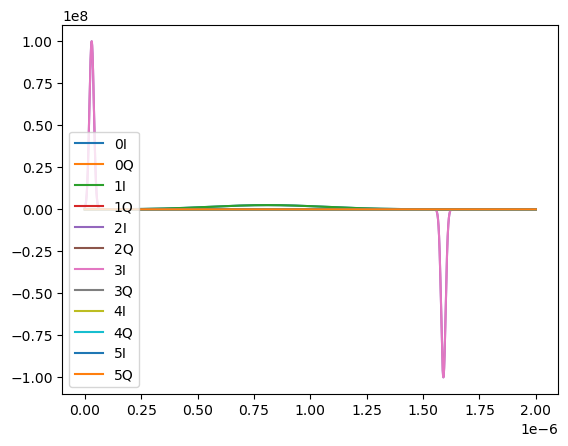

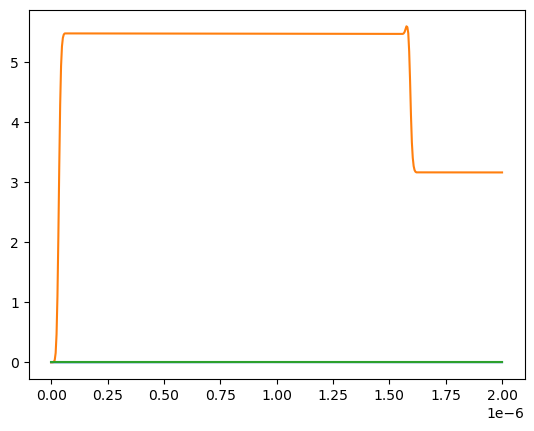

In [41]:
print(pulse_eval(H_r, pulse_config, r_dm_g10_func))
pulse_plot(pulse_config)
state_plot(H_r, pulse_config)

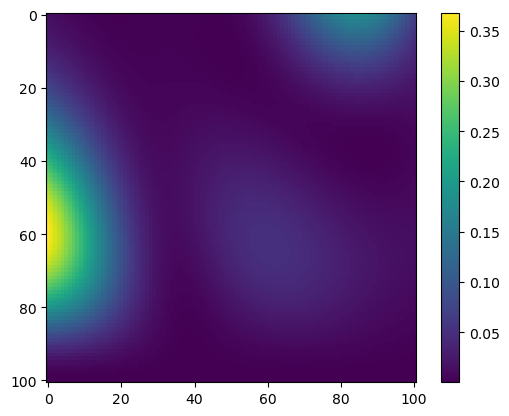

In [38]:
plt.imshow(out_list2[::-1])
plt.colorbar()
plt.show()

In [207]:
drive_gains = [10000000, 10000000, 10000000]
drive_sigmas = [0.20 * 1e-6, 0.01 * 1e-6, 0.01 * 1e-6]
drive_freqs = [wa, wc_A, wc_B]
drive_ts = [0.0 * 1e-6, 0.02 * 1e-6, 0.02 * 1e-6]

H_r = assemble_ti_hamil(H_0, element_ops, np.array(element_freqs) - np.array(drive_freqs))

amp_i = 0
amp_f = 5000000
n_amps = 101

test_amps = np.linspace(amp_i, amp_f, n_amps)

out_list1 = np.empty(n_amps)
for i, amp in enumerate(tqdm(test_amps)):
    pulse_config = [
    # {
    #     "ch": 2,  # Channel to play pulse on
    #     "gain": amp,  # Gain of pulse [DAC units]
    #     "freq": drive_freqs[1],  # Frequency to play pulse at [MHz]
    #     "sigma": drive_sigmas[1],  # Standard deviation of Gaussian [us]
    #     "t": 0.0 * 1e-6  #  # Time at which pulse is sent [us]
    # },
    {
        "ch": 0,  # Channel to play pulse on
        "gain": amp,  # Gain of pulse [DAC units]
        "freq": drive_freqs[0],  # Frequency to play pulse at [MHz]
        "sigma": drive_sigmas[0],  # Standard deviation of Gaussian [us]
        "t": 0.0 * 1e-6 #  # Time at which pulse is sent [us]
    },
    # {
    #     "ch": 2,  # Channel to play pulse on
    #     "gain": 0,  # Gain of pulse [DAC units]
    #     "freq": drive_freqs[1],  # Frequency to play pulse at [MHz]
    #     "sigma": drive_sigmas[1],  # Standard deviation of Gaussian [us]
    #     "t": 1.1 * 1e-6  # Time at which pulse is sent [us]
    # },
    # {
    #     "ch": 4,  # Channel to play pulse on
    #     "gain": drive_gains[2],  # Gain of pulse [DAC units]
    #     "freq": drive_freqs[2],  # Frequency to play pulse at [MHz]
    #     "sigma": drive_sigmas[2],  # Standard deviation of Gau    ssian [us]
    #     "t": drive_ts[2] + 2e-7  # Time at which pulse is sent [us]
    # }
    ]
    out_list1[i] = pulse_eval(H_r, pulse_config, r_x_e_func)

100%|██████████| 101/101 [06:52<00:00,  4.09s/it]


In [22]:
print(out_list1)

[-0.999998   -0.99937732 -0.99751654 -0.9944046  -0.99005779 -0.9844545
 -0.97762615 -0.96955377 -0.9602334  -0.94966195 -0.93794367 -0.92488029
 -0.91054938 -0.89495302 -0.87836386 -0.86019578 -0.84095237 -0.82051832
 -0.79871382 -0.77579198 -0.75147366 -0.72605862 -0.69934066 -0.67146616
 -0.64209547 -0.61170618 -0.58021413 -0.54709618 -0.51297989 -0.47776259
 -0.44101067 -0.40301743 -0.36423503 -0.32356393 -0.28224427 -0.23929083
 -0.19509507 -0.1495898  -0.10305652 -0.05531254 -0.0065016  -0.04371408
 -0.09521564 -0.14849639 -0.20211851 -0.25750308 -0.31416305 -0.37215771
 -0.43087668 -0.49144454 -0.55260904 -0.61521712 -0.67891685 -0.74370999
 -0.81008786 -0.87853841 -0.94703375 -1.01611858 -1.08742274 -1.16023472
 -1.23326335 -1.30835003 -1.38417932 -1.46148727 -1.53839491 -1.61877124
 -1.69780111 -1.77917476 -1.86054802 -1.94335265 -2.02718688 -2.11141419
 -2.19769025 -2.28341378 -2.36990389 -2.45645325 -2.54441031 -2.63218059
 -2.72063293 -2.80831549 -2.89826004 -2.98683486 -3.

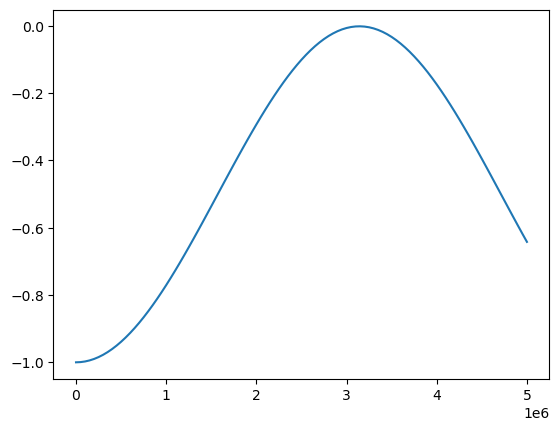

Max prob: -0.0023044843026078787
Max amp: 3150000.0


In [208]:
plt.plot(test_amps, out_list1)
plt.show()

m_prob = max(out_list1)
m_amp = test_amps[np.argmax(out_list1)]
print(f'Max prob: {m_prob}')
print(f'Max amp: {m_amp}')

trace: 0.9999999999999982
argmax: 3096
res: [3.74688010e-01 4.25711698e-02 1.32774545e-01 4.13148733e-01
 1.94321802e-02 1.58189635e-02 6.41381479e-04 2.85749787e-04
 4.76100881e-05 1.45069599e-04 1.46108626e-04 1.20333008e-04
 1.15774312e-04 4.96657904e-05 1.00739681e-05 1.63614065e-06]
0.04257116980965355


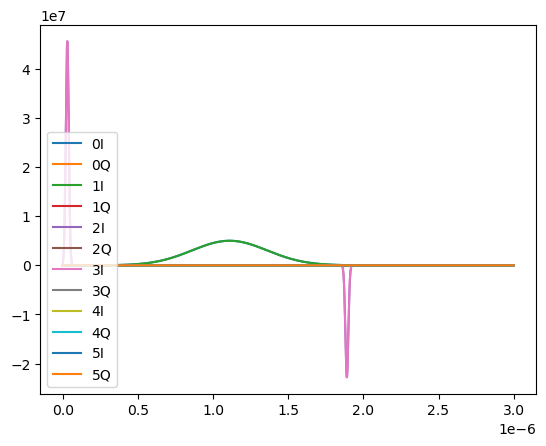

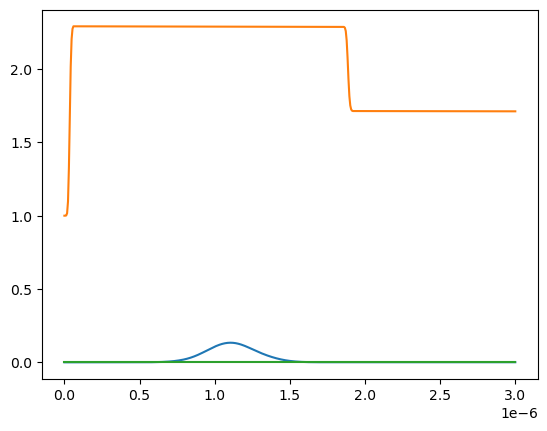

In [147]:
pulse_config = [
    {
        "ch": 2,  # Channel to play pulse on
        "gain": 1.14 * 40000000,  # Gain of pulse [DAC units]
        "freq": drive_freqs[1],  # Frequency to play pulse at [MHz]
        "sigma": drive_sigmas[1],  # Standard deviation of Gaussian [us]
        "t": 0.0 * 1e-6  #  # Time at which pulse is sent [us]
    },
    {
        "ch": 0,  # Channel to play pulse on
        "gain": 2 * 2500000,  # Gain of pulse [DAC units]
        "freq": drive_freqs[0],  # Frequency to play pulse at [MHz]
        "sigma": drive_sigmas[0],  # Standard deviation of Gaussian [us]
        "t": 0.36 * 1e-6 #  # Time at which pulse is sent [us]
    },
    {
        "ch": 2,  # Channel to play pulse on
        "gain": -0.57 * 40000000,  # Gain of pulse [DAC units]
        "freq": drive_freqs[1],  # Frequency to play pulse at [MHz]
        "sigma": drive_sigmas[1],  # Standard deviation of Gaussian [us]
        "t": 1.86 * 1e-6  # Time at which pulse is sent [us]
    },
]

print(pulse_eval(H_r, pulse_config, r_dm_g10_func))
pulse_plot(pulse_config)
state_plot(H_r, pulse_config)

0.7222610248599386


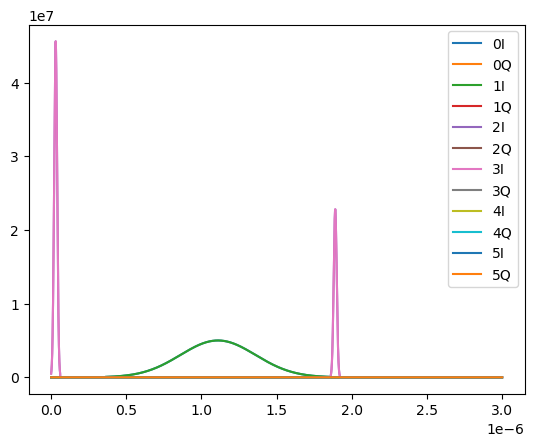

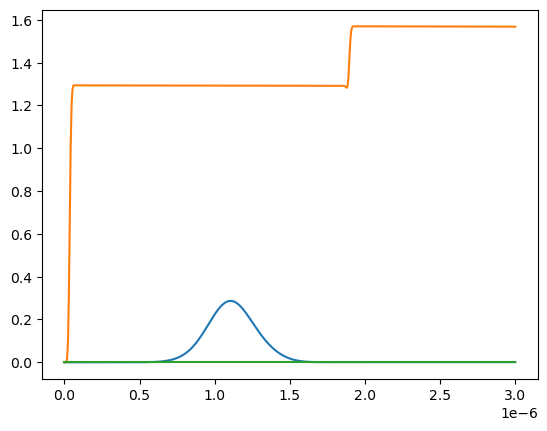

In [157]:
pulse_config = [
    {
        "ch": 2,  # Channel to play pulse on
        "gain": 1.14 * 40000000,  # Gain of pulse [DAC units]
        "freq": drive_freqs[1],  # Frequency to play pulse at [MHz]
        "sigma": drive_sigmas[1],  # Standard deviation of Gaussian [us]
        "t": 0.0 * 1e-6  #  # Time at which pulse is sent [us]
    },
    {
        "ch": 0,  # Channel to play pulse on
        "gain": 2 * 2500000,  # Gain of pulse [DAC units]
        "freq": drive_freqs[0],  # Frequency to play pulse at [MHz]
        "sigma": drive_sigmas[0],  # Standard deviation of Gaussian [us]
        "t": 0.36 * 1e-6 #  # Time at which pulse is sent [us]
    },
    {
        "ch": 2,  # Channel to play pulse on
        "gain": 0.57 * 40000000,  # Gain of pulse [DAC units]
        "freq": drive_freqs[1],  # Frequency to play pulse at [MHz]
        "sigma": drive_sigmas[1],  # Standard deviation of Gaussian [us]
        "t": 1.86 * 1e-6  # Time at which pulse is sent [us]
    },
]

# a = pulse_eval(H_r, pulse_config, r_dm_g10_func)
# b = pulse_eval(H_r, pulse_config, r_dm_g10_func)

print(pulse_eval(H_r, pulse_config, r_dm_g10_func))
pulse_plot(pulse_config)
state_plot(H_r, pulse_config)

In [221]:
def snap_opt_func(opts, *args):
    for i, opt in enumerate(opts):
        print(f'Param {i}: {opt}')
        
    drive_freqs = [opts[3], wc_A, wc_B]
    
    pulse_config = [
        {
            "ch": 2,  # Channel to play pulse on
            "gain": opts[0],  # Gain of pulse [DAC units]
            "freq": drive_freqs[1],  # Frequency to play pulse at [MHz]
            "sigma": drive_sigmas[1],  # Standard deviation of Gaussian [us]
            "t": 0.0 * 1e-6  #  # Time at which pulse is sent [us]
        },
        {
            "ch": 0,  # Channel to play pulse on
            "gain": opts[1],  # Gain of pulse [DAC units]
            "freq": drive_freqs[0],  # Frequency to play pulse at [MHz]
            "sigma": opts[4],  # Standard deviation of Gaussian [us]
            "t": opts[5]  # Time at which pulse is sent [us]
        },
        {
            "ch": 2,  # Channel to play pulse on
            "gain": opts[2],  # Gain of pulse [DAC units]
            "freq": drive_freqs[1],  # Frequency to play pulse at [MHz]
            "sigma": drive_sigmas[1],  # Standard deviation of Gaussian [us]
            "t": opts[6]  # Time at which pulse is sent [us]
        },
    ]
    # pulse_plot(pulse_config)
    H_r = assemble_ti_hamil(H_0, element_ops, np.array(element_freqs) - np.array(drive_freqs))
    cost = pulse_eval(H_r, pulse_config, r_dm_g10_func)
    print(f'cost: {cost}')
    return 1 - np.abs(cost)

In [ ]:
x0 = (48591238.265006766, 2 * 3150000, 24805317.882211916, 33459549321.872223, 0.20e-6, 0.01e-6, 1.18424426e-6)
bounds = ((-100000000, 100000000), (-10000000, 10000000), (-100000000, 100000000), (wa - (2 * chi_A), wa + (2 * chi_A)), (0.15e-6, 0.4e-6), (-5e-6, 5e-6), (0.0, 5e-7))
opt_res = minimize(snap_opt_func, x0=x0, method="Nelder-Mead", bounds=bounds)

Param 0: 48591238.265006766
Param 1: 6300000.0
Param 2: 24805317.882211916
Param 3: 33459549321.872223
Param 4: 2e-07
Param 5: 1e-08
Param 6: 1.18424426e-06
cost: 0.039900103461593533
Param 0: 51020800.17825711
Param 1: 6300000.0
Param 2: 24805317.882211916
Param 3: 33459549321.872223
Param 4: 2e-07
Param 5: 1e-08
Param 6: 1.18424426e-06
cost: 0.030466207485623897
Param 0: 48591238.265006766
Param 1: 6615000.0
Param 2: 24805317.882211916
Param 3: 33459549321.872223
Param 4: 2e-07
Param 5: 1e-08
Param 6: 1.18424426e-06


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.interpolate as spl
from utils import *

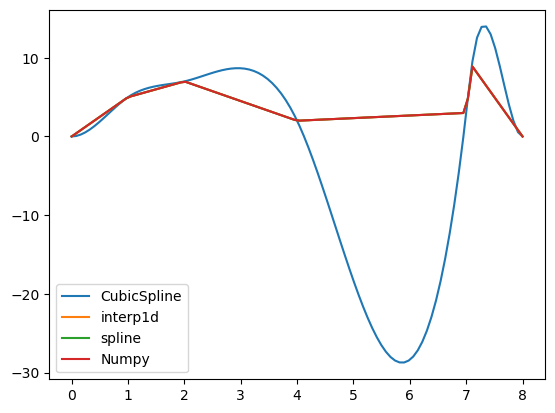

In [26]:
N = 100
xs = [0, 1, 2, 4, 7, 7.1, 8]
ys = [0, 5, 7, 2, 3, 9, 0]
x_plot = np.linspace(xs[0], xs[-1], N)
inte_cs = spl.CubicSpline(xs, ys, bc_type='clamped')
# inte_i1d = spl.interp1d(xs, ys, kind='nearest-up')
inte_spline = spl.make_interp_spline(xs, ys, k=1)
plt.plot(x_plot, inte_cs(x_plot), label="CubicSpline")
plt.plot(x_plot, inte_i1d(x_plot), label="interp1d")
plt.plot(x_plot, inte_spline(x_plot), label="spline")
plt.plot(x_plot, np.interp(x_plot, xs, ys), label="Numpy")
plt.legend()
plt.show()